 ## Contents:
1. [Data Visualization](#first-section)
2. [Data Processing:](#second-section)
    1. [Train Set](#second-section)
    2. [Test Set](#third-section)
3. [Linear Regression:](#fourth_section)
    1. [MLR](#fifth_section)
    2. [Ridge](#sixth_section)
    3. [Lasso](#seventh_section)
4. [Submission #1](#eighth_section)

# House Prices: Advanced Regression Techniques

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
import seaborn as sns

train = pd.read_csv('data/train.csv')
train = train.drop('Id', axis =1)
test = pd.read_csv('data/test.csv')

# Data Visualization: <a class="anchor" id="first-section"></a>
### What does the data look like?

In [2]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0, 0.5, 'Count')

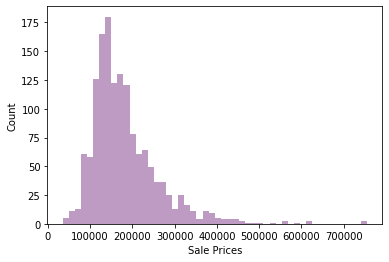

In [3]:
plt.hist(train.SalePrice, bins = 50, color = "#BD9BC2")
plt.xlabel('Sale Prices')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

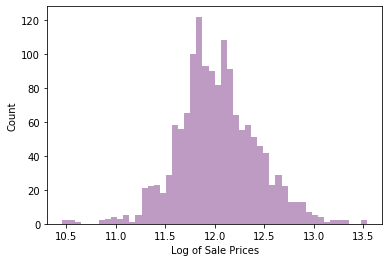

In [4]:
plt.hist(np.log(train.SalePrice), bins = 50, color = "#BD9BC2")
plt.xlabel('Log of Sale Prices')
plt.ylabel('Count')

In [7]:
# right skew to the target variable, but taking the log corrects corrects much of the issue

Text(0, 0.5, 'Count')

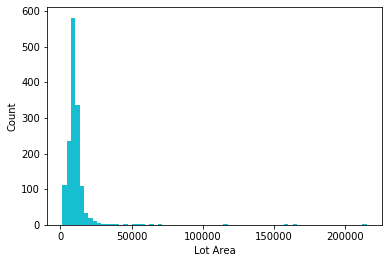

In [5]:
plt.hist(train.LotArea, bins = 70, color = 'tab:cyan')
plt.xlabel('Lot Area')
plt.ylabel('Count')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002297D9239B0>,
      dtype=object)

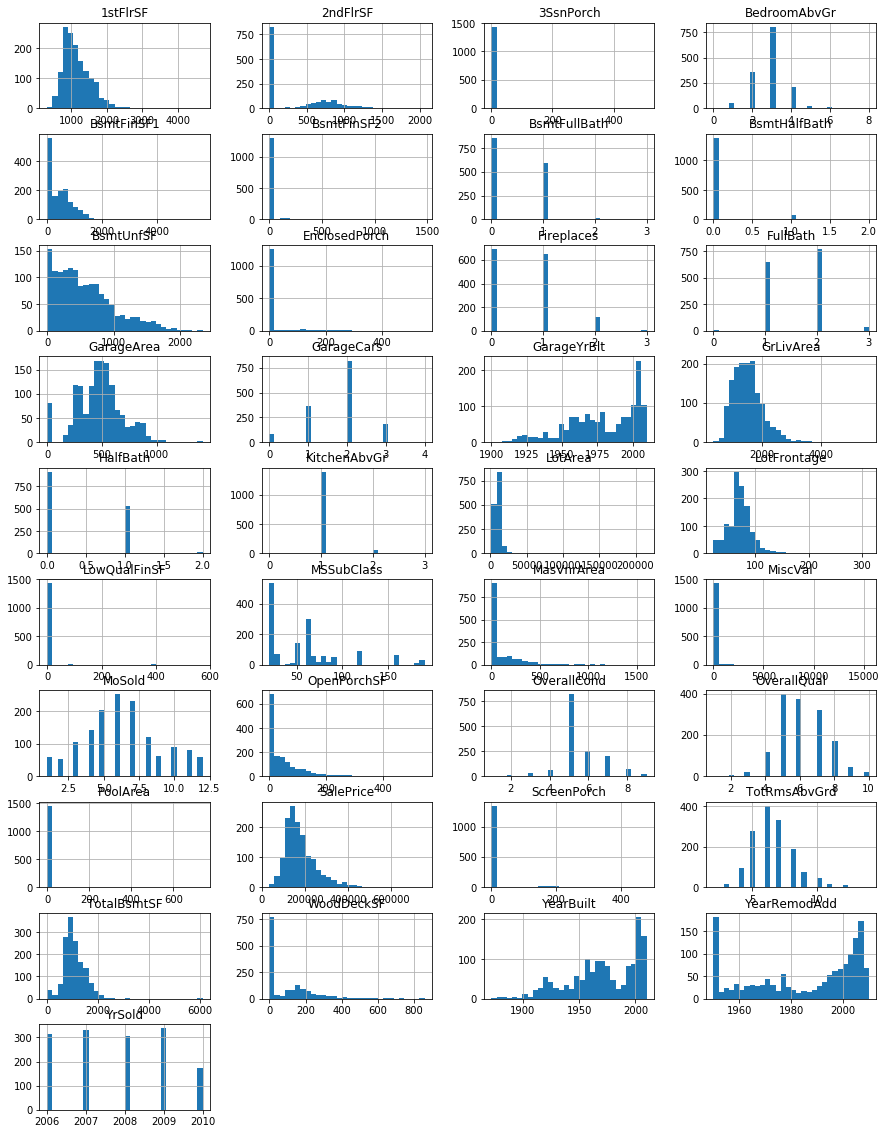

In [6]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.hist(layout = (10,4), bins = 30, figsize=(15,20))


In [7]:
skewed = ['1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GrLivArea', 'TotalBsmtSF', 'OpenPorchSF']

### Explore the relationship between sale price and other variables:

The top 5 positively & negatively correlated features:

In [8]:
numeric_features = train.select_dtypes(include=[np.number])
corr = numeric_features.corr()
corr[['SalePrice']].sort_values('SalePrice', ascending=False)[:10].style.background_gradient(cmap='RdBu_r')

,SalePrice
SalePrice,1
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [9]:
corr[['SalePrice']].sort_values('SalePrice', ascending=True)[:10].style.background_gradient(cmap='RdBu')

,SalePrice
KitchenAbvGr,-0.135907
EnclosedPorch,-0.128578
MSSubClass,-0.0842841
OverallCond,-0.0778559
YrSold,-0.0289226
LowQualFinSF,-0.0256061
MiscVal,-0.0211896
BsmtHalfBath,-0.0168442
BsmtFinSF2,-0.0113781
3SsnPorch,0.0445837


In [10]:
high_corr = corr[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']]
high_corr = high_corr[high_corr.index.isin(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF'])]
high_corr.sort_values('SalePrice', ascending=False).style.background_gradient(cmap='RdBu_r')

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF
SalePrice,1,0.790982,0.708624,0.640409,0.623431,0.613581
OverallQual,0.790982,1,0.593007,0.600671,0.562022,0.537808
GrLivArea,0.708624,0.593007,1,0.467247,0.468997,0.454868
GarageCars,0.640409,0.600671,0.467247,1,0.882475,0.434585
GarageArea,0.623431,0.562022,0.468997,0.882475,1,0.486665
TotalBsmtSF,0.613581,0.537808,0.454868,0.434585,0.486665,1


Inspecting the relationships further:

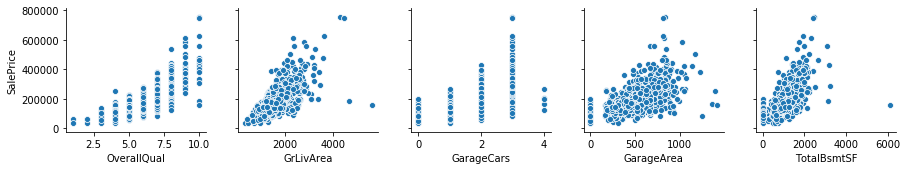

In [11]:
# top positively correlated variables
sns.pairplot(numeric_features[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']], 
            y_vars=['SalePrice'],
            x_vars=['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF'])

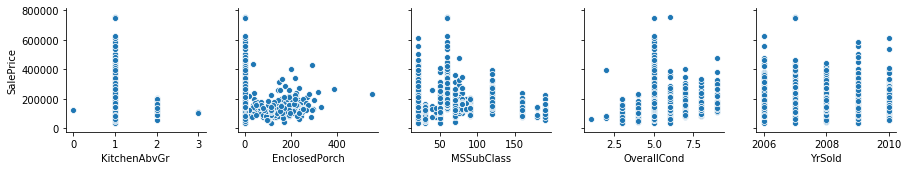

In [12]:
# top negatively correlated variables
sns.pairplot(numeric_features[['SalePrice', 'KitchenAbvGr', 'EnclosedPorch', 'MSSubClass', 'OverallCond', 'YrSold']],
            y_vars= ['SalePrice'], 
            x_vars = ['KitchenAbvGr', 'EnclosedPorch', 'MSSubClass', 'OverallCond', 'YrSold'])

Categorical Features

In [14]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


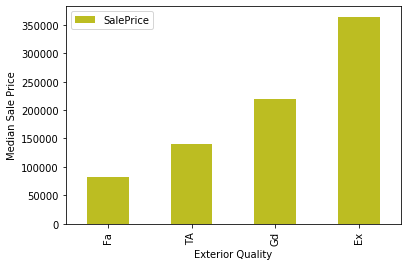

In [15]:
pivot = train.pivot_table(index='ExterQual', values='SalePrice', aggfunc=np.median)
pivot = pivot.sort_values('SalePrice')
pivot.plot(kind='bar', color='tab:olive')
plt.xlabel('Exterior Quality')
plt.ylabel('Median Sale Price')
#plt.xticks(rotation=0)
plt.show()

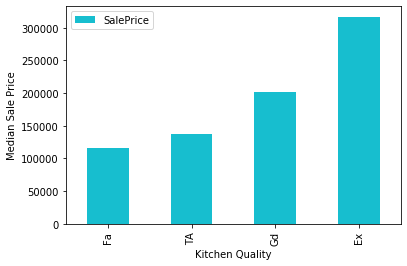

In [16]:
pivot = train.pivot_table(index='KitchenQual', values='SalePrice', aggfunc=np.median)
pivot = pivot.sort_values('SalePrice')
pivot.plot(kind='bar', color='tab:cyan')
plt.xlabel('Kitchen Quality')
plt.ylabel('Median Sale Price')
#plt.xticks(rotation=0)
plt.show()

# Data Processing<a class="anchor" id="second-section"></a>
Handle missingness and dummify categorical variables

### Outliers

Text(0, 0.5, 'Sale Price')

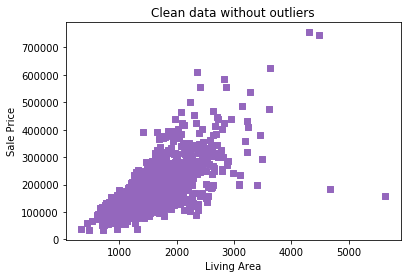

In [17]:
plt.scatter(train.GrLivArea, train.SalePrice, color='tab:purple', marker='s')
plt.title('Clean data without outliers')
plt.xlabel('Living Area')
plt.ylabel('Sale Price')

Text(0, 0.5, 'Sale Price')

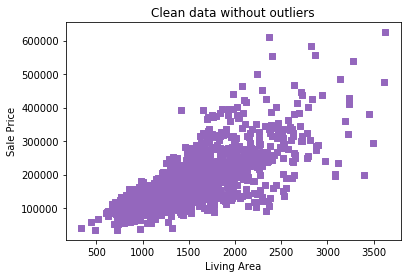

In [18]:
train = train[(train.GrLivArea<4000) & (train.SalePrice<700000)]
plt.scatter(train.GrLivArea, train.SalePrice, color='tab:purple', marker='s')
plt.title('Clean data without outliers')
plt.xlabel('Living Area')
plt.ylabel('Sale Price')

Take the log of skewed variables and drop variables with little to no variance:

In [19]:
from numpy import isneginf

low_variance = ['Street', 'Utilities', 'Heating', 'PoolArea','3SsnPorch', 'PoolQC', 'MiscFeature', 'RoofMatl', 'MiscVal',
               'BsmtHalfBath', 'Alley', 'Electrical', 'Fence', 'KitchenAbvGr', 'LowQualFinSF', 'Condition2']
train = train.drop(low_variance, axis=1)
for v in skewed:
    mask = np.log(train[v])
    mask[isneginf(mask)]=0
    train[v] = mask

C:\Users\bdbot\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


### Missingness

In [20]:
missingCols = train.isnull().any(axis=0)
nulls = pd.DataFrame(train[train.columns[missingCols]].isnull().sum().sort_values(ascending=False))
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
FireplaceQu,690
LotFrontage,259
GarageCond,81
GarageQual,81
GarageFinish,81
GarageYrBlt,81
GarageType,81
BsmtFinType2,38
BsmtExposure,38


Continuous Variables:
Can impute mean or 0. Using mean for now, and 0 for the variable where 0 makes sense

In [21]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.columns[numeric_features.isnull().any(axis=0)]

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [22]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights='distance')
numeric_features = pd.DataFrame(data=imputer.fit_transform(numeric_features), columns=numeric_features.columns, index=numeric_features.index)
#train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean()) # unclear why NA 
#train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean()) # better than other options
#train['MasVnrArea'] = train['MasVnrArea'].fillna(0) # NA is from no masonry veneer area

Categorical Variables:
Data description confirms that NAs here means the feature doesn't exist at the house. Since these are categorical, making the lack of feature a category is natural. One row seems to be missing completely at random from the 'Electrical' column, so I am dropping that row.

In [23]:
#train['PoolQC'] = train['PoolQC'].fillna('No Pool')
#train['MiscFeature'] = train['MiscFeature'].fillna('None')
#train['Alley'] = train['Alley'].fillna('No alley access')
#train['Fence'] = train['Fence'].fillna('No Fence')
train['FireplaceQu'] = train['FireplaceQu'].fillna('No Fireplace')
train['GarageCond'] = train['GarageCond'].fillna('No Garage')
train['GarageQual'] = train['GarageQual'].fillna('No Garage')
train['GarageFinish'] = train['GarageFinish'].fillna('No Garage')
train['GarageType'] = train['GarageType'].fillna('No Garage')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('No Basement')
train['BsmtExposure'] = train['BsmtExposure'].fillna('No Basement')
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('No Basement')
train['BsmtCond'] = train['BsmtCond'].fillna('No Basement')
train['BsmtQual'] = train['BsmtQual'].fillna('No Basement')
train['MasVnrType'] = train['MasVnrType'].fillna('None')
categoricals = train.select_dtypes(exclude=[np.number])

### Dummify Categorical Variables

In [24]:
# Features for LR use only:
dummified_features = pd.concat([numeric_features, categoricals], axis = 1)
dummified_features = dummified_features[train.columns].drop('SalePrice', axis =1)
# Binary Categorical Variables can be changed to 0 or 1:
#dummified_features['Street'] = dummified_features['Street'].apply(lambda x: 0 if x == 'Pave' else 1)
#dummified_features['Utilities'] = dummified_features['Utilities'].apply(lambda x: 0 if x == 'AllPub' else 1)
dummified_features['CentralAir'] = dummified_features['CentralAir'].apply(lambda x: 0 if x == 'N' else 1)

# MSSubClass refers to categories, but is currently an integer type. Changing to string type, since the distance 
# between categories doesn't mean anything.
dummified_features['MSSubClass'] = dummified_features['MSSubClass'].astype(str)

In [25]:
categoricals = dummified_features.select_dtypes(exclude=[np.number])
categoricals.columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [26]:
print(dummified_features.shape)
for variable in categoricals.columns:
    dummy = pd.get_dummies(dummified_features[variable], prefix=variable)
    dummy.drop('_'.join([variable, dummified_features[variable][1]]), axis=1, inplace=True) # 
    dummified_features = dummified_features.drop(variable, axis=1)  # drop the original feature
    dummified_features = pd.concat([dummified_features, dummy], axis=1) # concat original df and dummy horizontally
print(dummified_features.shape)

(1456, 63)
(1456, 228)


In [27]:
print(dummified_features.columns)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New',
       'SaleType_Oth', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Partial'],
      dtype='object', length=228)


### Standarize

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(dummified_features)

dummified_features =pd.DataFrame(data=scaler.transform(dummified_features), columns=dummified_features.columns, index=dummified_features.index)

In [39]:
dummified_features.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial
count,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,...,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03
mean,6.847392e-17,7.157164e-17,-1.633309e-16,7.434529e-17,-9.782887e-16,4.852269e-15,-2.960086e-16,2.874685e-17,-5.718869e-17,9.527635e-17,...,1.464030e-17,-7.027060e-16,-9.199753e-17,1.852913e-17,-2.054218e-16,-9.150190e-18,2.479797e-16,-6.891237e-17,-4.403529e-18,-1.002708e-16
std,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,...,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00
min,-2.123086e+00,-9.281155e-01,-3.716479e+00,-4.109470e+00,-3.285242e+00,-1.686572e+00,-5.776420e-01,-1.410823e+00,-2.890821e-01,-3.040477e+00,...,-7.886549e-02,-5.870178e-02,-5.870178e-02,-2.997004e-01,-4.543890e-02,-2.715627e-01,-5.248639e-02,-9.116057e-02,-1.180152e-01,-3.037648e-01
25%,-4.417509e-01,-2.952139e-01,-7.950627e-01,-5.174614e-01,-5.692198e-01,-8.752398e-01,-5.776420e-01,-1.410823e+00,-2.890821e-01,-1.284536e-01,...,-7.886549e-02,-5.870178e-02,-5.870178e-02,-2.997004e-01,-4.543890e-02,-2.715627e-01,-5.248639e-02,-9.116057e-02,-1.180152e-01,-3.037648e-01
50%,-4.312209e-02,-9.944678e-02,-6.470858e-02,-5.174614e-01,2.698005e-02,4.204704e-01,-5.776420e-01,5.773854e-01,-2.890821e-01,2.829747e-01,...,-7.886549e-02,-5.870178e-02,-5.870178e-02,-2.997004e-01,-4.543890e-02,-2.715627e-01,-5.248639e-02,-9.116057e-02,-1.180152e-01,-3.037648e-01
75%,4.274874e-01,1.155699e-01,6.656456e-01,3.805408e-01,9.544021e-01,9.290669e-01,3.529798e-01,7.839824e-01,-2.890821e-01,5.663707e-01,...,-7.886549e-02,-5.870178e-02,-5.870178e-02,-2.997004e-01,-4.543890e-02,-2.715627e-01,-5.248639e-02,-9.116057e-02,-1.180152e-01,-3.037648e-01
max,1.050009e+01,2.077593e+01,2.856708e+00,3.074547e+00,1.285624e+00,1.219693e+00,8.432918e+00,1.162173e+00,8.839724e+00,1.138350e+00,...,1.267982e+01,1.703526e+01,1.703526e+01,3.336665e+00,2.200757e+01,3.682391e+00,1.905256e+01,1.096966e+01,8.473488e+00,3.292020e+00


# Process Test Data: <a class="anchor" id="third-section"></a>

In [28]:
test = test.drop(low_variance, axis=1)

for v in skewed:
    mask = np.log(test[v])
    mask[isneginf(mask)]=0
    test[v] = mask

C:\Users\bdbot\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


### Missingness

In [29]:
missingCols = test.isnull().any(axis=0)
nulls = pd.DataFrame(test[test.columns[missingCols]].isnull().sum().sort_values(ascending=False))
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
FireplaceQu,730
LotFrontage,227
GarageQual,78
GarageFinish,78
GarageYrBlt,78
GarageCond,78
GarageType,76
BsmtCond,45
BsmtExposure,44


In [30]:
numeric_test = test.select_dtypes(include=[np.number])
numeric_test.columns[numeric_test.isnull().any(axis=0)]

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'GarageYrBlt', 'GarageCars',
       'GarageArea'],
      dtype='object')

In [31]:
imputer = KNNImputer(n_neighbors=2, weights='distance')
numeric_test = pd.DataFrame(data=imputer.fit_transform(numeric_test), 
                                columns=numeric_test.columns, index=numeric_test.index)
numeric_test.shape

(1459, 31)

In [32]:
#test['PoolQC'] = test['PoolQC'].fillna('No Pool')
#test['MiscFeature'] = test['MiscFeature'].fillna('None')
#test['Alley'] = test['Alley'].fillna('No alley access')
#test['Fence'] = test['Fence'].fillna('No Fence')
test['FireplaceQu'] = test['FireplaceQu'].fillna('No Fireplace')
test['GarageFinish'] = test['GarageFinish'].fillna('No Garage')
test['GarageType'] = test['GarageType'].fillna('No Garage')
test['BsmtExposure'] = test['BsmtExposure'].fillna('No Basement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('No Basement')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('No Basement')
test['MasVnrType'] = test['MasVnrType'].fillna('None')
#test['Utilities'] = test['Utilities'].fillna(test['Utilities'].mode()[0])
test['Functional'] = test['Functional'].fillna(test['Functional'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])

test['GarageCond'] = test['GarageCond'].fillna('No Garage')
test['GarageQual'] = test['GarageQual'].fillna('No Garage')
test['BsmtCond'] = test['BsmtCond'].fillna('No Basement')
test['BsmtQual'] = test['BsmtQual'].fillna('No Basement')
test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])

test_categoricals = test.select_dtypes(exclude=[np.number])
test_categoricals.shape

(1459, 33)

### Dummify Categorical Variables

In [33]:
dummified_test_features = pd.concat([numeric_test, test_categoricals], axis = 1)
dummified_test_features = dummified_test_features[test.columns].drop('Id', axis =1)

#dummified_test_features['Street'] = dummified_test_features['Street'].apply(lambda x: 0 if x == 'Pave' else 1)
#dummified_test_features['Utilities'] = dummified_test_features['Utilities'].apply(lambda x: 0 if x == 'AllPub' else 1)
dummified_test_features['CentralAir'] = dummified_test_features['CentralAir'].apply(lambda x: 0 if x == 'N' else 1)

# MSSubClass refers to categories, but is currently an integer type. Changing to string type, since the distance 
# between categories doesn't mean anything.
dummified_test_features['MSSubClass'] = dummified_test_features['MSSubClass'].astype(str)

In [34]:
test_categoricals = dummified_test_features.select_dtypes(exclude=[np.number])
test_categoricals.columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [35]:
print(dummified_test_features.shape)
for variable in test_categoricals:
    dummy = pd.get_dummies(dummified_test_features[variable], prefix=variable)
    dummy.drop('_'.join([variable, dummified_test_features[variable][1]]), axis=1, inplace=True) # 
    dummified_test_features = dummified_test_features.drop(variable, axis=1)  # drop the original feature
    dummified_test_features = pd.concat([dummified_test_features, dummy], axis=1) # concat original df and dummy horizontally
print(dummified_test_features.shape)

(1459, 63)
(1459, 224)


### Match Features with Training Data (if necessary)

In [36]:
# 256 columns instead of 272. Need to make these match:
missing_cols = set(dummified_features.columns) - set(dummified_test_features.columns)
for c in missing_cols:
    dummified_test_features[c] = 0
dummified_test_features = dummified_test_features[dummified_features.columns]
print(dummified_test_features.shape)
print(dummified_features.shape)

(1459, 228)
(1456, 228)


# Linear Regression Models <a class="anchor" id="fourth_section"></a>

## Mutiple Linear Regression <a class="anchor" id="fifth_section"></a>

In [37]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = np.log(train.SalePrice)
X = dummified_features

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=135, test_size=.20)
mlr = linear_model.LinearRegression()
saturated_model = mlr.fit(X_train, y_train)

In [38]:
print ("Error for the training data : ", 1-saturated_model.score(X_train, y_train))
print ("Error for the test data : ", 1-saturated_model.score(X_test, y_test))

Error for the training data :  0.05001938757397573
Error for the test data :  0.08944862849251511


In [39]:
train_predictions = saturated_model.predict(X_train)
test_predictions = saturated_model.predict(X_test)

# log is already taken on predicted values and actual values, and we'll keep it that way as Kaggle's evaluation method takes 
# the log to reduce the impact of very high house prices
print ('Train RMSE :', np.sqrt(mean_squared_error(y_train, train_predictions)))
print ('Test RMSE :', np.sqrt(mean_squared_error(y_test, test_predictions)))

Train RMSE : 0.08764116023920104
Test RMSE : 0.1230753189790948


Substantial overfitting in the saturated model / Not too bad on with the re-processed data.

In [40]:
import statsmodels.api as sm
X_Constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_Constant)
results = model.fit()
print(results.summary()) 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     82.80
Date:                Tue, 12 May 2020   Prob (F-statistic):               0.00
Time:                        13:02:46   Log-Likelihood:                 1182.1
No. Observations:                1164   AIC:                            -1928.
Df Residuals:                     946   BIC:                            -825.2
Df Model:                         217                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

C:\Users\bdbot\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Check assumptions of MLR:

Linearity:

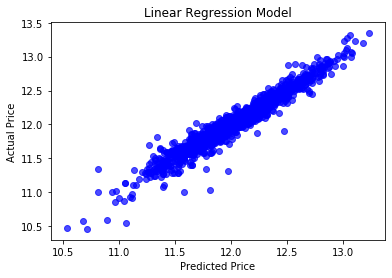

In [41]:
plt.scatter(saturated_model.predict(X), y, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

Normally distributed errors:

(array([  1.,   0.,   1.,   0.,   2.,   1.,   0.,   1.,   0.,   1.,   3.,
          5.,  13.,  29.,  46., 114., 245., 354., 312., 177.,  82.,  37.,
         17.,   7.,   3.,   2.,   0.,   1.,   1.,   1.]),
 array([-0.77719269, -0.73327628, -0.68935987, -0.64544346, -0.60152705,
        -0.55761064, -0.51369423, -0.46977782, -0.42586141, -0.38194501,
        -0.3380286 , -0.29411219, -0.25019578, -0.20627937, -0.16236296,
        -0.11844655, -0.07453014, -0.03061373,  0.01330268,  0.05721908,
         0.10113549,  0.1450519 ,  0.18896831,  0.23288472,  0.27680113,
         0.32071754,  0.36463395,  0.40855036,  0.45246677,  0.49638317,
         0.54029958]),
 <a list of 30 Patch objects>)

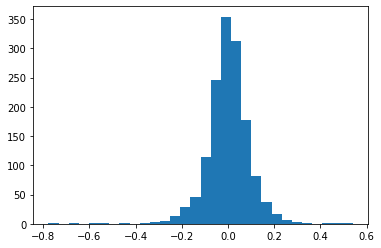

In [42]:
residuals = y - saturated_model.predict(X)
plt.hist(residuals, bins = 30)

Constant variance and independent Errors:

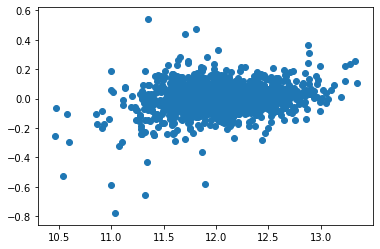

In [43]:
plt.scatter(y, residuals)

Multicollinearity:

Using all variables requires using many related variables, such as the numerous variables relating to the basement or the garage. These variables add different but related information. Penalized linear regression will be used to address multicollinearity issues, decrease variance, and increase accuracy. Lasso will have the additional benefit of feature selection.

## Ridge Linear Regression <a class="anchor" id="sixth_section"></a>

In [65]:
from sklearn.linear_model import Lasso, Ridge

ridge = Ridge()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=135, test_size=.20)

ridge.set_params(alpha = 0, normalize = False)
ridge.fit(X_train, y_train)

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [66]:
print ("Error for the training data : ", ridge.score(X_train, y_train))
print ("Error for the test data : ", ridge.score(X_test, y_test))

Error for the training data :  -242.79531104169416
Error for the test data :  -4.778953724397249e+24


In [67]:
train_predictions = ridge.predict(X_train)
test_predictions = ridge.predict(X_test)

print ('Train RMSE :', np.sqrt(mean_squared_error(y_train, train_predictions)))
#print ('Test RMSE :', np.sqrt(mean_squared_error(np.log(y_test), np.log(test_predictions))))

Train RMSE : 6.1185935926668105


In [68]:
coefs = []
intercepts = []
R2_train  = []
R2_test  = []
alphaRange = np.linspace(1e-3, 6,20)
for alpha in alphaRange:
        ridge.set_params(alpha=alpha, normalize=True)  
        ridge.fit(X_train, y_train)
        intercepts.append(ridge.intercept_)
        coefs.append(ridge.coef_)
        R2_train.append(ridge.score(X_train, y_train))
        R2_test.append(ridge.score(X_test, y_test))

Text(0.5, 1.0, 'Change of Ridge Slopes Varying Alpha')

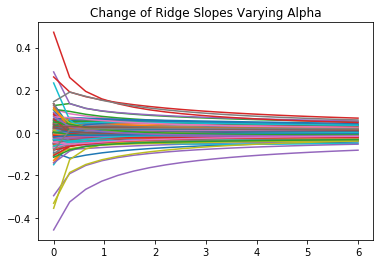

In [69]:
coefs = pd.DataFrame(np.array(coefs), columns=X.columns)

for name in coefs.columns:
    plt.plot(alphaRange, coefs[name], label=name)  
plt.title('Change of Ridge Slopes Varying Alpha')

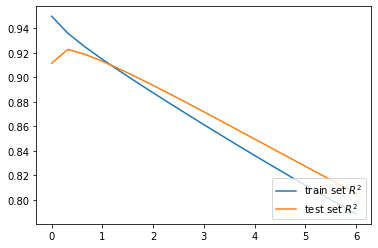

In [70]:
plt.plot(alphaRange, R2_train, label=r'train set $R^2$')
plt.plot(alphaRange, R2_test, label=r'test set $R^2$')
plt.legend(loc=4)

In [71]:
ridge.set_params(alpha=1.2, normalize=True)
ridge_best_alpha = ridge.fit(X_train, y_train)
print(ridge_best_alpha.score(X_train, y_train))
print(ridge_best_alpha.score(X_test, y_test))

0.9091671529741868
0.9095628141270115


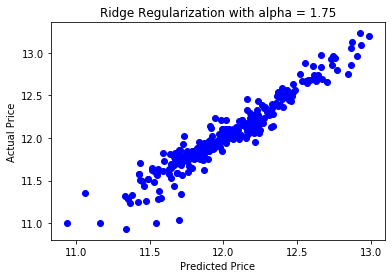

In [72]:
predictions = ridge_best_alpha.predict(X_test)
plt.scatter(predictions, y_test, alpha=1, color='b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Ridge Regularization with alpha = {}'.format(1.75))
plt.show()

In [73]:
print ('RMSE :', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE : 0.12375354460222764


No significant improvement with ridge regression, but we do have a more robust model from it.

## Lasso Linear Regression <a class="anchor" id="seventh_section"></a>

In [53]:
lasso = Lasso()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, test_size=.20)

lasso.set_params(alpha = 0,normalize = False)
lasso.fit(X_train, y_train)

C:\Users\bdbot\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  """
C:\Users\bdbot\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\bdbot\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.712877649984643, tolerance: 0.017845159866850473
  positive)


Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [54]:
print ("Error for the training data : ", 1-lasso.score(X_train, y_train))
print ("Error for the test data : ", 1-lasso.score(X_test, y_test))

Error for the training data :  0.05281967418783817
Error for the test data :  0.08089969713159872


In [55]:
train_predictions = lasso.predict(X_train)
test_predictions = lasso.predict(X_test)

print ('Train RMSE :', np.sqrt(mean_squared_error(y_train, train_predictions)))
print ('Test RMSE :', np.sqrt(mean_squared_error(y_test, test_predictions)))

Train RMSE : 0.08998737645323263
Test RMSE : 0.11740674729028258


In [56]:
coefs = []
intercepts = []
R2_train  = []
R2_test  = []
alphaRange = np.linspace(1e-3, 1, 10)
for alpha in alphaRange:
        lasso.set_params(alpha=alpha, normalize=False)  
        lasso.fit(X_train, y_train)
        intercepts.append(lasso.intercept_)
        coefs.append(lasso.coef_)
        R2_train.append(lasso.score(X_train, y_train))
        R2_test.append(lasso.score(X_test, y_test))

Text(0.5, 1.0, 'Change of Lasso Slopes Varying Alpha')

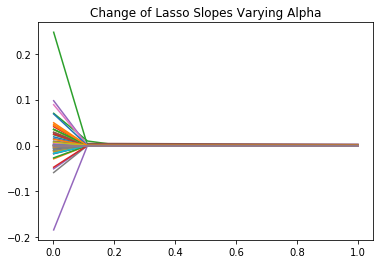

In [57]:
coefs = pd.DataFrame(np.array(coefs), columns=X.columns)

for name in coefs.columns:
    plt.plot(alphaRange, coefs[name], label=name)  
plt.title('Change of Lasso Slopes Varying Alpha')

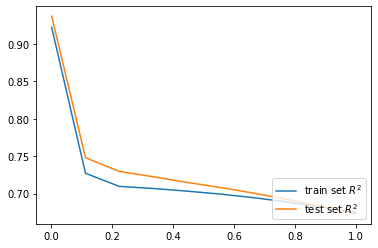

In [58]:
plt.plot(alphaRange, R2_train, label=r'train set $R^2$')
plt.plot(alphaRange, R2_test, label=r'test set $R^2$')
plt.legend(loc=4)

In [59]:
lasso.set_params(alpha=0.1, normalize=False)
best_alpha = lasso.fit(X_train, y_train)
print(best_alpha.score(X_train, y_train))
print(best_alpha.score(X_test, y_test))

0.7479115191225904
0.7652806234786298


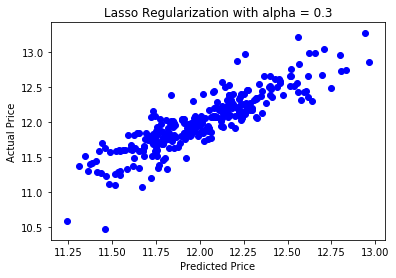

In [60]:
predictions = best_alpha.predict(X_test)
plt.scatter(predictions, y_test, alpha=1, color='b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Lasso Regularization with alpha = {}'.format(0.3))
plt.show()

In [61]:
print ('RMSE :', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE : 0.19998346083540963


Strictly worse performance using Lasso.

### Predicting Test Set / Submission to Kaggle: <a class="anchor" id="eighth_section"></a>

Best performance from the Ridge model, so I am use it to submit predictions of the test data.

In [74]:
predictions = np.exp(ridge_best_alpha.predict(dummified_test_features))
submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = predictions
submission.to_csv('submission1.csv', index=False)

In [ ]:
# Scored: 0.15293